# NCSC Report Web Scraping

### Introduction

In this project we'll look at web scraping and parallelisation. We do this in the contect of the NCSC Weekly threat reports which we will get using selenium. We'll then using multiprocessing to parallelise this process and determine the speed increase we can get from this.

We first import all the libraries we need. BeautifulSoup was initially considered for use due to the inspiration referenced but it turned out to be incompatible with this form of web scraping. It doesn't provide java support which is required for the articles we want to obtain so we changed to selenium since we can utilise the webdrivers here to access the articles. To use selenium please download the chrome driver, chromedriver.exe, from [here](https://sites.google.com/a/chromium.org/chromedriver/downloads) and follow the installation guides [here](https://selenium-python.readthedocs.io/installation.html).

In [1]:
import requests

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

import re
import pandas as pd
from IPython.display import clear_output
import pickle 
import datetime
import numpy as np
import matplotlib.pyplot as plt 

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk

In [2]:
np.random.seed(15394)

The below options are adjusted for ease of use and to allow us to run the code while performing other tasks. The options mean that we no longer get the usual 'pop-up' from the chrome driver.

In [3]:
chrome_options = Options()
chrome_options.add_argument("headless")
chrome_options.add_argument("no-sandbox")
chrome_options.add_argument("disable-gpu")

### Getting Links

The first step here is to grab the links we need for all the articles necessary. We do this using the Chrome webdriver. *Note that the link used below only grabs the links of all the articles up to 23/04/2021. As more articles are produced, we need to update this code to access the rest.*

In [4]:
linkbrowser = webdriver.Chrome(executable_path='chromedriver.exe',chrome_options=chrome_options)

<ipython-input-4-ce34f7b2b338>:1: DeprecationWarning: use options instead of chrome_options
  linkbrowser = webdriver.Chrome(executable_path='chromedriver.exe',chrome_options=chrome_options)


In [5]:
linkbrowser.get('https://www.ncsc.gov.uk/section/keep-up-to-date/threat-reports?q=&defaultTypes=report&sort=date%2Bdesc&writtenFor=Large+organisations&rows=232')

Here we actually access our links after accessing the page. We use the xpath search with '//a' as the path we search for to find all hyperlinks present on the age. After this, we check for 'report/weekly' in the string for the link. The first cell grabs all links from the page so we end up with links such as those to the careers site which aren't what we're looking for.

In [6]:
# occasionally this code errors with a headless message. 
# Rerunning the cell fixes this completely and I'm not 100% sure why it occurs since it runs fine after repeating it
links=[]
while links == []:
    WebDriverWait(linkbrowser, 10).until(EC.presence_of_element_located((By.XPATH, ".//a")))

    for a in linkbrowser.find_elements_by_xpath('.//a'):
        links.append(a.get_attribute('href'))

In [7]:
report_links = []
for ind, link in enumerate(links):
    if 'report/weekly' in link:
        report_links.append(link)

In [8]:
report_links

['https://www.ncsc.gov.uk/report/weekly-threat-report-7th-may-2021',
 'https://www.ncsc.gov.uk/report/weekly-threat-report-30th-april-2021',
 'https://www.ncsc.gov.uk/report/weekly-threat-report-23rd-april-2021',
 'https://www.ncsc.gov.uk/report/weekly-threat-report-16th-april-2021',
 'https://www.ncsc.gov.uk/report/weekly-threat-report-12th-april-2021',
 'https://www.ncsc.gov.uk/report/weekly-threat-report-2nd-april-2021',
 'https://www.ncsc.gov.uk/report/weekly-threat-report-26th-march-2021',
 'https://www.ncsc.gov.uk/report/weekly-threat-report-19th-march-2021',
 'https://www.ncsc.gov.uk/report/weekly-threat-report-12th-march-2021',
 'https://www.ncsc.gov.uk/report/weekly-threat-report-5th-march-2021',
 'https://www.ncsc.gov.uk/report/weekly-threat-report-26th-february-2021',
 'https://www.ncsc.gov.uk/report/weekly-threat-report-19th-february-2021',
 'https://www.ncsc.gov.uk/report/weekly-threat-report-12th-february-2021',
 'https://www.ncsc.gov.uk/report/weekly-threat-report-5th-fe

### Getting Articles

We now search each link for the title, article and tags in it. 

The function get_articles is our web scraper for this job. *Note that this is also used in the parallelised code*. The code searches classes for the title, body and tags of each report to compile them into a data frame. The tags section often provides multiple tags so we use reg-ex to seperate these tags from each other to obtain a list of the independent tags.

The cell below this calls the function for each link we have obtained and then creates a pickle dump of the data frame.

In [9]:
def get_articles(link):
    
    gbrowser = webdriver.Chrome(executable_path='chromedriver.exe',chrome_options=chrome_options)
    gbrowser.get(link)
    WebDriverWait(gbrowser, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "pcf-title")))
    
    articles = []
    t = []
    
    try:

        title = gbrowser.find_elements_by_class_name("pcf-title")
        try:
            title = title.text
        except:
            title = title[0].text

        main = gbrowser.find_elements_by_class_name('pcf-BodyText')
        try:
            articles = main.text
        except AttributeError:
            for i in range(len(main)):
                articles.append(main[i].text)

        topics = gbrowser.find_elements_by_class_name('topic-tags-container')
        topics = topics[0].text[7:]
        count = len(re.findall('([A-Z])', topics))
        for num1, i in enumerate(re.finditer('([A-Z])',topics)):
            for num2, j in enumerate(re.finditer('([A-Z])',topics)):
                if num1 == num2 + 1:
                    t.append(topics[j.start():i.end()-1])
                elif num1 == num2 & num1 == count - 1:
                    t.append(topics[i.start():])

    except:
        pass
    
    data = {'Title': title,'Article': articles,'topics': t}
    gbrowser.close()
    
    return data

In [10]:
try:
    
    my_df = pickle.load(open('../Data/NCSC Reports.p','rb'))

except:
    
    begin_time = datetime.datetime.now()
    my_df = []
    for num, link in enumerate(report_links):
        data = []
        data = get_articles(link)
        
        my_df.append(data)
        if num % 10 == 0:
            clear_output(wait=True)
            print('Scraping article number {}'.format(num))

    my_df = pd.DataFrame(my_df)
    my_df['Links'] = report_links
    pickle.dump(my_df, open('../Data/NCSC Reports.p','wb'))

    end_time = datetime.datetime.now()
    print('Time Taken: %s' % (end_time - begin_time))

In [11]:
pd.set_option('display.max_rows', 500)
my_df

,Title,Article,topics,Links
0,Weekly Threat Report 23rd April 2021,[The NCSC is aware that a malicious piece of s...,"[Cyber attack, Cyber strategy, Education, Vuln...",https://www.ncsc.gov.uk/report/weekly-threat-r...
1,Weekly Threat Report 16th April 2021,[Cyber security researchers have uncovered a s...,"[Cyber strategy, Patching, Vulnerabilities]",https://www.ncsc.gov.uk/report/weekly-threat-r...
2,Weekly Threat Report 12th April 2021,"[Cyber security researchers, Esentire, have wa...","[Phishing, Social media, Personal data, Vulner...",https://www.ncsc.gov.uk/report/weekly-threat-r...
3,Weekly Threat Report 2nd April 2021,[The UK education sector continues to face an ...,"[Education, Incident management, Secure design...",https://www.ncsc.gov.uk/report/weekly-threat-r...
4,Weekly Threat Report 26th March 2021,[Earlier this month Microsoft confirmed that s...,"[Cyber attack, Education, Mitigation, Patching...",https://www.ncsc.gov.uk/report/weekly-threat-r...
5,Weekly Threat Report 19th March 2021,[Courier service company Fastway said this wee...,"[Cyber attack, Personal data, Phishing, Vulner...",https://www.ncsc.gov.uk/report/weekly-threat-r...
6,Weekly Threat Report 12th March 2021,[There has been a rise in vulnerability report...,"[Cyber threat, Risk management, Vulnerabilities]",https://www.ncsc.gov.uk/report/weekly-threat-r...
7,Weekly Threat Report 5th March 2021,[Microsoft has released a number of security u...,"[Cyber threat, Patching, Personal data, Phishi...",https://www.ncsc.gov.uk/report/weekly-threat-r...
8,Weekly Threat Report 26th February 2021,[VMware have released security updates to addr...,"[Cyber attack, Vulnerabilities]",https://www.ncsc.gov.uk/report/weekly-threat-r...
9,Weekly Threat Report 19th February 2021,"[Scam emails, which aim to convince people to ...","[Cyber attack, Personal data, Phishing, Secure...",https://www.ncsc.gov.uk/report/weekly-threat-r...


In [12]:
pd.reset_option('all')

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



C:\Users\corri\anaconda3\lib\site-packages\pandas\_config\config.py:620: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
C:\Users\corri\anaconda3\lib\site-packages\pandas\_config\config.py:620: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


Here we run our parallelised code. The code is implemented in NSCS-Report-Parallelisation.py where comments are added to explain the process. We use a worker pool to scrape the data much faster than we can without parallelisation.

In [13]:
try:
    my_df_pl = pickle.load(open('../Data/NCSC Reports Parallelised.p','rb'))
except:
    %run -i NCSC-Report-Parallelisation.py
    my_df_pl = pd.DataFrame(results)
    my_df_pl['Links'] = report_links
    pickle.dump(my_df_pl, open('../Data/NCSC Reports Parallelised.p','wb'))

In [14]:
my_df_pl

,Title,Article,topics,Links
0,Weekly Threat Report 23rd April 2021,[The NCSC is aware that a malicious piece of s...,"[Cyber attack, Cyber strategy, Education, Vuln...",https://www.ncsc.gov.uk/report/weekly-threat-r...
1,Weekly Threat Report 16th April 2021,[Cyber security researchers have uncovered a s...,"[Cyber strategy, Patching, Vulnerabilities]",https://www.ncsc.gov.uk/report/weekly-threat-r...
2,Weekly Threat Report 12th April 2021,"[Cyber security researchers, Esentire, have wa...","[Phishing, Social media, Personal data, Vulner...",https://www.ncsc.gov.uk/report/weekly-threat-r...
3,Weekly Threat Report 2nd April 2021,[The UK education sector continues to face an ...,"[Education, Incident management, Secure design...",https://www.ncsc.gov.uk/report/weekly-threat-r...
4,Weekly Threat Report 26th March 2021,[Earlier this month Microsoft confirmed that s...,"[Cyber attack, Education, Mitigation, Patching...",https://www.ncsc.gov.uk/report/weekly-threat-r...
...,...,...,...,...
216,Weekly Threat Report 28th October 2016,[Malware-infected ATMs compromise Indian debit...,[Cyber threat],https://www.ncsc.gov.uk/report/weekly-threat-r...
217,Weekly Threat Report 24th October 2016,[Threat assessment and trend analysis\nOnline ...,[Cyber threat],https://www.ncsc.gov.uk/report/weekly-threat-r...
218,Weekly Threat Report 17th October 2016,[New Trojan used in financial attacks\nSymante...,[Cyber threat],https://www.ncsc.gov.uk/report/weekly-threat-r...
219,Weekly Threat Report 10th October 2016,[Threat assessment and trend analysis\nDressco...,[Cyber threat],https://www.ncsc.gov.uk/report/weekly-threat-r...


In [15]:
try: 
    my_df_pla = pickle.load(open('../Data/NCSC Reports Parallelised Asynchronous.p', 'rb'))
except:
    %run -i NCSC-Report-Parallelisation-Asynch.py
    my_df_pla = pd.DataFrame(results)
    my_df_pla['Links'] = report_links
    pickle.dump(my_df_pla, open('../Data/NCSC Reports Parallelised Asynchronous.p','wb'))    

In [16]:
my_df_pla

,Title,Article,topics,Links
0,Weekly Threat Report 23rd April 2021,[The NCSC is aware that a malicious piece of s...,"[Cyber attack, Cyber strategy, Education, Vuln...",https://www.ncsc.gov.uk/report/weekly-threat-r...
1,Weekly Threat Report 16th April 2021,[Cyber security researchers have uncovered a s...,"[Cyber strategy, Patching, Vulnerabilities]",https://www.ncsc.gov.uk/report/weekly-threat-r...
2,Weekly Threat Report 12th April 2021,"[Cyber security researchers, Esentire, have wa...","[Phishing, Social media, Personal data, Vulner...",https://www.ncsc.gov.uk/report/weekly-threat-r...
3,Weekly Threat Report 2nd April 2021,[The UK education sector continues to face an ...,"[Education, Incident management, Secure design...",https://www.ncsc.gov.uk/report/weekly-threat-r...
4,Weekly Threat Report 26th March 2021,[Earlier this month Microsoft confirmed that s...,"[Cyber attack, Education, Mitigation, Patching...",https://www.ncsc.gov.uk/report/weekly-threat-r...
...,...,...,...,...
216,Weekly Threat Report 28th October 2016,[Malware-infected ATMs compromise Indian debit...,[Cyber threat],https://www.ncsc.gov.uk/report/weekly-threat-r...
217,Weekly Threat Report 24th October 2016,[Threat assessment and trend analysis\nOnline ...,[Cyber threat],https://www.ncsc.gov.uk/report/weekly-threat-r...
218,Weekly Threat Report 17th October 2016,[New Trojan used in financial attacks\nSymante...,[Cyber threat],https://www.ncsc.gov.uk/report/weekly-threat-r...
219,Weekly Threat Report 10th October 2016,[Threat assessment and trend analysis\nDressco...,[Cyber threat],https://www.ncsc.gov.uk/report/weekly-threat-r...


In [17]:
a = my_df_pla['Title'][0]
a[21:]

'23rd April 2021'

When using my own computer, which has 16 cores, we see a speed increase of almost 300% so 20% per core using the parallelised versio. This is a massive increase on speed compared to the non-parallelised version, and is similar to the asynchronous version. Since we will pull the data frames from pickle files from now on, for reference, the times were:
- 17:40.70 (Un-parallelised)
- 06:49.86 (Parallelised)
- 07:12.74 (Parallelised Asynchronous)

After reviewing all three data frames, we can see that we obtain the correct data in all three cases. The data is split into Titles, Articles and Topics for later use in LDA models.

One final adjustment is made to this data set for now. We remove the 'Weekly Threat Report' from the beginning of each title.

In [18]:
for i in range(my_df_pla.shape[0]):
    my_df_pla['Title'][i] = my_df_pla['Title'][i][21:]

In [19]:
my_df_pla

,Title,Article,topics,Links
0,23rd April 2021,[The NCSC is aware that a malicious piece of s...,"[Cyber attack, Cyber strategy, Education, Vuln...",https://www.ncsc.gov.uk/report/weekly-threat-r...
1,16th April 2021,[Cyber security researchers have uncovered a s...,"[Cyber strategy, Patching, Vulnerabilities]",https://www.ncsc.gov.uk/report/weekly-threat-r...
2,12th April 2021,"[Cyber security researchers, Esentire, have wa...","[Phishing, Social media, Personal data, Vulner...",https://www.ncsc.gov.uk/report/weekly-threat-r...
3,2nd April 2021,[The UK education sector continues to face an ...,"[Education, Incident management, Secure design...",https://www.ncsc.gov.uk/report/weekly-threat-r...
4,26th March 2021,[Earlier this month Microsoft confirmed that s...,"[Cyber attack, Education, Mitigation, Patching...",https://www.ncsc.gov.uk/report/weekly-threat-r...
...,...,...,...,...
216,28th October 2016,[Malware-infected ATMs compromise Indian debit...,[Cyber threat],https://www.ncsc.gov.uk/report/weekly-threat-r...
217,24th October 2016,[Threat assessment and trend analysis\nOnline ...,[Cyber threat],https://www.ncsc.gov.uk/report/weekly-threat-r...
218,17th October 2016,[New Trojan used in financial attacks\nSymante...,[Cyber threat],https://www.ncsc.gov.uk/report/weekly-threat-r...
219,10th October 2016,[Threat assessment and trend analysis\nDressco...,[Cyber threat],https://www.ncsc.gov.uk/report/weekly-threat-r...


In [20]:
my_df_pla.to_csv('../Data/NCSC Reports.csv')

### EDA

We first review the topics that the NCSC assigns to each article. From a brief review, I suspect that the 'tagging' has become more comprehensive over the last year and therefore will be more expansive.

In [21]:
assigned_topics = my_df_pla['topics']

In [22]:
topic_count = np.zeros(len(assigned_topics))
for i in range(len(assigned_topics)):
    cnt = len(assigned_topics[i])
    topic_count[i] = cnt

Text(0, 0.5, 'Number of assigned Topics')

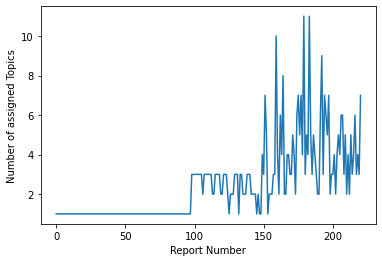

In [23]:
topic_count = np.flip(topic_count)
x = np.arange(len(assigned_topics))

plt.figure()
plt.plot(x, topic_count)
plt.xlabel('Report Number')
plt.ylabel('Number of assigned Topics')

So there is no linear relationship between the increase of assigned topics and date the report was produced although it does appear that up until the 100th report, we had only 'Cyber threat' assigned whereas after roughly 150 reports, we start assigning a variety of topics. Therefore, we would presume that the assigned topics are not particularly effective descriptors of the articles.

Lets ensure that we haven't missed any entries. The code above should identify any events where we miss titles, articles or tags but we'll check here too to ensure this.

In [24]:
my_df_pla.isnull().any()

Title      False
Article    False
topics     False
Links      False
dtype: bool

So we conclude that we've not got any missing entries, amazing!

#### Reg-Ex

Lets have a review of a few of the entries for articles and see if any reg-ex is required.

In [25]:
samplenum = np.random.randint(my_df_pla.shape[0])
sample = my_df_pla['Article'][samplenum]
print('Sample taken is Article: {} from the {}. This has {} articles'.format(samplenum, my_df_pla['Title'][samplenum], len(sample)))
print(sample)

Sample taken is Article: 45 from the 22nd May 2020. This has 2 articles
['Users of the QTS operating system have been urged to ensure it is updated to the latest version.\nA bug bounty report has found that QNAP NAS devices running older versions of the QTS operating system may be attacked through a number of vulnerabilities which, when chained together, would allow an attacker to gain remote access.\nThe NCSC recommends following vendor best practice advice in the mitigation of vulnerabilities. In this case the most important aspect is to install the latest version of the QTS operating system.\nIt is good practice to always install and use the latest software version and update it regularly because these contain vital security fixes.\nFurther details of the vulnerabilities can be found in the report.', "Earlier this week, EasyJet revealed that it had suffered a cyber attack and was in the process of contacting affected customers.\nIn a statement, the company said that the email addres

One of the things we can identify from this random sample is that we have quotation marks seperating the different articles (along with commas). Furthermore, we notice that \n is included often within the articles and this should be removed before any LDA is done.

In [26]:
# testing for the sample to remove \n
re.sub(r'\n', " ",sample[0])

'Users of the QTS operating system have been urged to ensure it is updated to the latest version. A bug bounty report has found that QNAP NAS devices running older versions of the QTS operating system may be attacked through a number of vulnerabilities which, when chained together, would allow an attacker to gain remote access. The NCSC recommends following vendor best practice advice in the mitigation of vulnerabilities. In this case the most important aspect is to install the latest version of the QTS operating system. It is good practice to always install and use the latest software version and update it regularly because these contain vital security fixes. Further details of the vulnerabilities can be found in the report.'

In [27]:
def remove_para(articles):
    
    articles = articles
    num = len(articles)
    reg_ex_articles = [None] * (len(articles))

    for i in range(num):
        article = articles[i]
        article = re.sub(r'\n', " ", article)
        reg_ex_articles[i] = article
    reg_ex_articles = ' '.join(reg_ex_articles)

    
    
    return reg_ex_articles

In [28]:
for i in range(my_df_pla.shape[0]):
    
    articles = my_df_pla['Article'][i]
    r_articles = remove_para(articles)
    my_df_pla['Article'][i] = r_articles
    

We could parallelise this but since we're only running on 222 entries, this is very quick and doesn't need it.

In [29]:
my_df_pla

,Title,Article,topics,Links
0,23rd April 2021,The NCSC is aware that a malicious piece of sp...,"[Cyber attack, Cyber strategy, Education, Vuln...",https://www.ncsc.gov.uk/report/weekly-threat-r...
1,16th April 2021,Cyber security researchers have uncovered a se...,"[Cyber strategy, Patching, Vulnerabilities]",https://www.ncsc.gov.uk/report/weekly-threat-r...
2,12th April 2021,"Cyber security researchers, Esentire, have war...","[Phishing, Social media, Personal data, Vulner...",https://www.ncsc.gov.uk/report/weekly-threat-r...
3,2nd April 2021,The UK education sector continues to face an i...,"[Education, Incident management, Secure design...",https://www.ncsc.gov.uk/report/weekly-threat-r...
4,26th March 2021,Earlier this month Microsoft confirmed that so...,"[Cyber attack, Education, Mitigation, Patching...",https://www.ncsc.gov.uk/report/weekly-threat-r...
...,...,...,...,...
216,28th October 2016,Malware-infected ATMs compromise Indian debit ...,[Cyber threat],https://www.ncsc.gov.uk/report/weekly-threat-r...
217,24th October 2016,Threat assessment and trend analysis Online Sh...,[Cyber threat],https://www.ncsc.gov.uk/report/weekly-threat-r...
218,17th October 2016,New Trojan used in financial attacks Symantec ...,[Cyber threat],https://www.ncsc.gov.uk/report/weekly-threat-r...
219,10th October 2016,Threat assessment and trend analysis Dresscode...,[Cyber threat],https://www.ncsc.gov.uk/report/weekly-threat-r...


We should create a feature for each possible topic. We'll first find out how many topics we have.

In [30]:
topic_dict = {}
for i in range(my_df_pla.shape[0]):
    
    topics = my_df_pla['topics'][i]
    
    for j in range(len(topics)):
        
        topic = topics[j]
        
        if topic in topic_dict:
            topic_dict[topic] = topic_dict[topic] + 1
        else:
            topic_dict[topic] = 1
            
p_topics = [key for key in topic_dict.keys()]
print('There are {} possible topics. These are {}.'.format(len(topic_dict), p_topics))

There are 41 possible topics. These are ['Cyber attack', 'Cyber strategy', 'Education', 'Vulnerabilities', 'Secure design and development', 'Research & ', 'Academia', 'Patching', 'Phishing', 'Social media', 'Personal data', 'Incident management', 'Mitigation', 'Cyber threat', 'Risk management', 'Bulk data', 'Logging', 'Remote working', 'Devices', 'Passwords', 'Mobile device', 'Access control', 'Security monitoring', 'Internet of ', 'Things', 'End user device', 'Security architecture', 'Exercising', 'Cloud', 'Video conferencing', 'Artificial intelligence', 'Authentication', 'Critical ', 'National ', 'Infrastructure (', 'C', 'N', 'I)', 'Penetration testing', 'Operational security', 'People-centred security'].


From this we can identify a few errors: Research & Academia, Internet of Things and Critical National Infrastructure are sperated. Lets adjust this.

In [31]:
topic_dict['Research & Academia'] = topic_dict.pop('Research & ')
topic_dict.pop('Academia')
topic_dict['Internet of Things'] = topic_dict.pop('Internet of ')
topic_dict.pop('Things')
topic_dict['Critical National Infrastructure'] = topic_dict.pop('Critical ')
topic_dict.pop('National ')
topic_dict.pop('Infrastructure (')
topic_dict.pop('C')
topic_dict.pop('N')
topic_dict.pop('I)')

2

In [32]:
topic_dict

{'Cyber attack': 66,
 'Cyber strategy': 3,
 'Education': 6,
 'Vulnerabilities': 82,
 'Secure design and development': 6,
 'Patching': 17,
 'Phishing': 37,
 'Social media': 4,
 'Personal data': 24,
 'Incident management': 11,
 'Mitigation': 18,
 'Cyber threat': 178,
 'Risk management': 3,
 'Bulk data': 2,
 'Logging': 1,
 'Remote working': 4,
 'Devices': 13,
 'Passwords': 8,
 'Mobile device': 2,
 'Access control': 2,
 'Security monitoring': 10,
 'End user device': 2,
 'Security architecture': 2,
 'Exercising': 2,
 'Cloud': 3,
 'Video conferencing': 3,
 'Artificial intelligence': 1,
 'Authentication': 2,
 'Penetration testing': 1,
 'Operational security': 2,
 'People-centred security': 2,
 'Research & Academia': 3,
 'Internet of Things': 2,
 'Critical National Infrastructure': 2}

So we've solved this issue! This is something we'll need to consider when creating features but this should be a problem we can solve (we'll look for 'Research & ') when creating this feature.

In [33]:
for key in topic_dict.keys():
    print(key)

Cyber attack
Cyber strategy
Education
Vulnerabilities
Secure design and development
Patching
Phishing
Social media
Personal data
Incident management
Mitigation
Cyber threat
Risk management
Bulk data
Logging
Remote working
Devices
Passwords
Mobile device
Access control
Security monitoring
End user device
Security architecture
Exercising
Cloud
Video conferencing
Artificial intelligence
Authentication
Penetration testing
Operational security
People-centred security
Research & Academia
Internet of Things
Critical National Infrastructure


One of the interesting things we see here is that remote working is one of the tags given. We would assume this is a recent COVID development, and thus the articles should be from the last year or so. This is checked within my own code along with some further EDA that can be conducted but is ommitted here to allow for better flow of the project.

### References

1. [Selenium](https://selenium-python.readthedocs.io/index.html)
2. [Getting Links](https://pythonspot.com/selenium-get-links/)
3. [Enumerate](https://realpython.com/python-enumerate/)
4. [Inspiration](https://www.youtube.com/watch?v=F1kZ39SvuGE)
5. [Parallelisation](https://stackoverflow.com/questions/9786102/how-do-i-parallelize-a-simple-python-loop)
7. [Multi-Processing](https://medium.com/swlh/5-step-guide-to-parallel-processing-in-python-ac0ecdfcea09)
8. [Parallelisation of for loops](https://stackoverflow.com/questions/51325705/parallelize-for-loop-in-python-3)